In [2]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16,
        "figure.constrained_layout.use": False}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=3, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd

from fiesta.plot import corner_plot, LightcurvePlotter
from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.inference.likelihood import EMLikelihood
from fiesta.utils import load_event_data

from nmma.em.io import loadEvent
from nmma.em.model import GRBLightCurveModel
#from nmma.em.likelihood import OpticalLightCurve


2025-06-20 23:31:42.395289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750455102.798528   25711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750455102.912320   25711 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750455103.768816   25711 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750455103.768834   25711 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750455103.768835   25711 computation_placer.cc:177] computation placer alr

Install wrapt_timeout_decorator if you want timeout simulations.


/home/enlil/hkoehn/miniconda3/envs/nmma_x_fiesta/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)

data = load_event_data("./data/injection_afterglowpy_gaussian.dat")

posterior_fiesta =  pd.DataFrame(dict(np.load("./outdir_fiesta/posterior.npz")))


In [6]:
model = AfterglowFlux(name="afgpy_gaussian",
                      filters=data.keys())

likelihood = EMLikelihood(model,
                          data,
                          data.keys(),
                          tmin=1e-2, 
                          tmax = 200.0,
                          trigger_time=params["trigger_time"],
                          detection_limit = None,
                          fixed_params={"luminosity_distance": 40.0, "redshift": 0.0}
                          )

t_model, surrogate_true_mag = model.predict(params)

23:31 fiesta INFO    : Loading surrogate afgpy_gaussian. This surrogate should only be used in the following parameter ranges:
23:31 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
23:31 fiesta INFO    : 	 log10_E0: (47, 57)
23:31 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
23:31 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
23:31 fiesta INFO    : 	 log10_n0: (-6, 2)
23:31 fiesta INFO    : 	 p: (2.01, 3)
23:31 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
23:31 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
23:31 fiesta INFO    : Surrogate afgpy_gaussian is loading with the following filters: ['X-ray-5keV', 'besselli', 'bessellv', 'radio-6GHz', 'uvot::b'].
23:31 fiesta INFO    : Loaded for surrogate afgpy_gaussian from /nfs/aya/work/hkoehn/fiesta/fiesta/src/fiesta/surrogates/GRB/afgpy_gaussian_CVAE/model.
23:31 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
23:31 fiesta INFO    : No detection limit is given. Putting it to infinity.
23:31 fiest

In [43]:
def conversion_function(sample):
    converted_sample = sample
    converted_sample["thetaWing"] = converted_sample["thetaCore"] * converted_sample["alphaWing"]
    converted_sample["epsilon_tot"] = 10**(converted_sample["log10_epsilon_B"]) + 10**(converted_sample["log10_epsilon_e"]) 
    converted_sample["counterjet"] = True
    return converted_sample, ["epsilon_tot", "thetaWing"]

nmma_model = GRBLightCurveModel(
                           parameter_conversion=conversion_function,
                           jetType=0,
                           filters=list(data.keys())[:-1],
                           sample_times=np.logspace(np.log10(1e-2), np.log10(200), 100))

_, nmma_true_mag = nmma_model.generate_lightcurve(np.logspace(np.log10(1e-2), np.log10(200), 100), params)

In [44]:
lc_plotter = LightcurvePlotter(posterior=posterior_fiesta,
                               likelihood=likelihood)

KeyError: 'uvot::b'

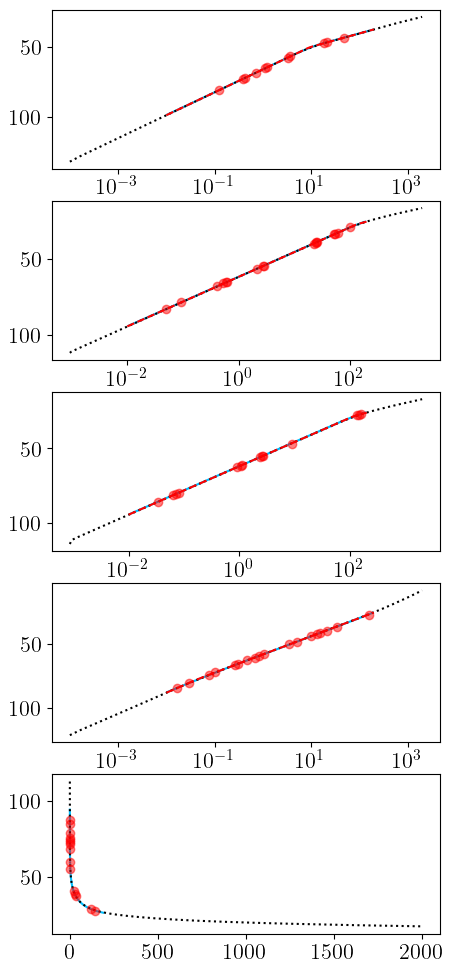

In [45]:
fig, ax = plt.subplots(5,1, figsize=(5, 12))

for cax, filt in zip(ax, data.keys()):
    lc_plotter.plot_data(cax, filt, color="red", alpha=0.5)
    lc_plotter.plot_best_fit_lc(cax, filt, color="deepskyblue")
    cax.plot(t_model, surrogate_true_mag[filt], color="black", linestyle="dotted")
    cax.plot(np.logspace(np.log10(1e-2), np.log10(200), 100), nmma_true_mag[filt] + 5*np.log10(40e6) - 5, color="red", linestyle="dashed")
    cax.set_xscale("log")
    cax.invert_yaxis()

In [47]:
likelihood(params)

Array(10.879115, dtype=float32)

In [ ]:
from nmma.em.likelihood import OpticalLightCurve

likelihood_kwargs = dict(
    light_curve_model=nmma_model,
    light_curve_data=data,
    filters = list(data.keys())[:-1],
    trigger_time = params["trigger_time"],
    tmin=1e-2,
    tmax = 200.0,
    systematics_file=None)

nmma_likelihood = OpticalLightCurve(**likelihood_kwargs)

nmma_likelihood.parameters = params
nmma_likelihood.parameters["timeshift"] = 0.

In [46]:
nmma_likelihood.log_likelihood()

-55.655350377781545